In [548]:
import tensorflow as tf
import pandas as pd
import xarray as xr
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Deep learning model
from keras.layers import Dropout, Flatten, GlobalMaxPooling1D, Input, Dense, Reshape, Concatenate, Embedding
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping

In [549]:
metar_data = pd.read_csv('../00_data_preparation/metar/metar_dataset_with_airport_location.csv')
#training_data = pd.read_csv('../01_data_analyzation/file_height_2021_01.csv')
#validation_data = pd.read_csv('../01_data_analyzation/file_height_2021_02.csv')
testing_data = pd.read_csv('../01_data_analyzation/file_height0_2022_02_01_09.csv')
training_data = pd.read_csv('../01_data_analyzation/file_height_2021_02_01_09.csv')

In [550]:
y_train = pd.read_csv('../01_data_analyzation/metar_file_file_height_2021_02_01_09.csv')
y_test = pd.read_csv('../01_data_analyzation/metar_file_height_2022_02_01_09.csv')

In [551]:
y_train.rename(columns={'airport_identifier': 'airport'}, inplace=True)
y_test.rename(columns={'airport_identifier': 'airport'}, inplace=True)

In [552]:
y_train['airport'].nunique()

71

In [553]:
training_data['airport'].nunique()

69

In [554]:
merged_data_train = pd.merge(y_train, training_data, on=['airport', 'time'], how='inner')
merged_data_test = pd.merge(y_test, testing_data, on=['airport', 'time'], how='inner')

In [555]:
training_data = merged_data_train.drop(columns=['contain_FZ'])
testing_data = merged_data_test.drop(columns=['contain_FZ'])

In [556]:
y_train = merged_data_train['contain_FZ']
y_test = merged_data_test['contain_FZ']

In [557]:
training_data

,airport,time,air_temperature_0m,fog_area_fraction,surface_air_pressure,air_pressure_at_sea_level
0,ENAL,2021-02-01 00:00:00,277.285796,0.000031,99610.329728,99647.811148
1,ENAL,2021-02-01 01:00:00,277.855323,0.000506,99605.680698,99642.889456
2,ENAL,2021-02-01 02:00:00,277.692794,0.000049,99576.191119,99614.730695
3,ENAL,2021-02-01 03:00:00,277.610191,0.000000,99572.909236,99609.618528
4,ENAL,2021-02-01 04:00:00,277.629007,0.000000,99548.594203,99585.806027
...,...,...,...,...,...,...
10615,ENZV,2021-02-08 20:00:00,262.339323,0.000000,101924.154348,102165.472709
10616,ENZV,2021-02-08 21:00:00,261.811705,0.000000,101954.185109,102195.573329
10617,ENZV,2021-02-08 22:00:00,261.540230,0.000000,101936.507816,102177.617176
10618,ENZV,2021-02-08 23:00:00,261.577304,0.000000,101902.635259,102143.746073


In [167]:
training_data['time'].nunique()

193

In [21]:
training_data['airport_id'] = pd.factorize(training_data['airport'])[0]
testing_data['airport_id'] = pd.factorize(testing_data['airport'])[0]

In [194]:
training_data

,airport,time,air_temperature_0m,fog_area_fraction,surface_air_pressure,air_pressure_at_sea_level
0,ENAL,2021-02-01 00:00:00,277.285796,0.000031,99610.329728,99647.811148
1,ENAL,2021-02-01 01:00:00,277.855323,0.000506,99605.680698,99642.889456
2,ENAL,2021-02-01 02:00:00,277.692794,0.000049,99576.191119,99614.730695
3,ENAL,2021-02-01 03:00:00,277.610191,0.000000,99572.909236,99609.618528
4,ENAL,2021-02-01 04:00:00,277.629007,0.000000,99548.594203,99585.806027
...,...,...,...,...,...,...
10615,ENZV,2021-02-08 20:00:00,262.339323,0.000000,101924.154348,102165.472709
10616,ENZV,2021-02-08 21:00:00,261.811705,0.000000,101954.185109,102195.573329
10617,ENZV,2021-02-08 22:00:00,261.540230,0.000000,101936.507816,102177.617176
10618,ENZV,2021-02-08 23:00:00,261.577304,0.000000,101902.635259,102143.746073


## Embed *airport_identifier* with one hot encoding

In [558]:
# Rule of thumb for number of embeddings: min(50, num_categories/2)
min(50, 67/2)

33.5

In [559]:
data_params = ['air_temperature_0m', 'fog_area_fraction', 'surface_air_pressure', 'air_pressure_at_sea_level']

In [560]:
scaler = StandardScaler()
training_data[data_params] = scaler.fit_transform(training_data[data_params])

In [561]:
training_data

,airport,time,air_temperature_0m,fog_area_fraction,surface_air_pressure,air_pressure_at_sea_level
0,ENAL,2021-02-01 00:00:00,0.674246,-0.142505,-0.988241,-2.020470
1,ENAL,2021-02-01 01:00:00,0.741856,-0.132551,-0.990896,-2.024700
2,ENAL,2021-02-01 02:00:00,0.722562,-0.142115,-1.007742,-2.048903
3,ENAL,2021-02-01 03:00:00,0.712756,-0.143143,-1.009617,-2.053297
4,ENAL,2021-02-01 04:00:00,0.714990,-0.143143,-1.023506,-2.073764
...,...,...,...,...,...,...
10615,ENZV,2021-02-08 20:00:00,-1.100106,-0.143143,0.333510,0.143495
10616,ENZV,2021-02-08 21:00:00,-1.162741,-0.143143,0.350665,0.169367
10617,ENZV,2021-02-08 22:00:00,-1.194969,-0.143143,0.340567,0.153933
10618,ENZV,2021-02-08 23:00:00,-1.190568,-0.143143,0.321218,0.124821


In [562]:
# Using label encoder to change the airport-column into integer labels
label_encoder = LabelEncoder()
training_data['airport_id'] = label_encoder.fit_transform(training_data['airport'])
testing_data['airport_id'] = label_encoder.fit_transform(testing_data['airport'])

In [563]:
training_data

,airport,time,air_temperature_0m,fog_area_fraction,surface_air_pressure,air_pressure_at_sea_level,airport_id
0,ENAL,2021-02-01 00:00:00,0.674246,-0.142505,-0.988241,-2.020470,0
1,ENAL,2021-02-01 01:00:00,0.741856,-0.132551,-0.990896,-2.024700,0
2,ENAL,2021-02-01 02:00:00,0.722562,-0.142115,-1.007742,-2.048903,0
3,ENAL,2021-02-01 03:00:00,0.712756,-0.143143,-1.009617,-2.053297,0
4,ENAL,2021-02-01 04:00:00,0.714990,-0.143143,-1.023506,-2.073764,0
...,...,...,...,...,...,...,...
10615,ENZV,2021-02-08 20:00:00,-1.100106,-0.143143,0.333510,0.143495,66
10616,ENZV,2021-02-08 21:00:00,-1.162741,-0.143143,0.350665,0.169367,66
10617,ENZV,2021-02-08 22:00:00,-1.194969,-0.143143,0.340567,0.153933,66
10618,ENZV,2021-02-08 23:00:00,-1.190568,-0.143143,0.321218,0.124821,66


In [564]:
# Extract newest registered param values
newest_training_data = training_data.groupby('airport_id').last()

In [565]:
newest_training_data = newest_training_data[data_params]

In [566]:
airport_input = Input(shape=(1,), name='embed_airport_input')
param_data_input = Input(shape=(4,), name='param_data_input')
# newest_param_data_input = Input(shape=(4,), name='newest_param_data_input')

In [567]:
# Prepare embedded layer and flatten
embedding_airports = Embedding(input_dim=num_airports, output_dim=embed_dim_airports, input_length=1)(airport_input)
flatten_airports = Flatten()(embedding_airports)

In [568]:
concatenated_input = Concatenate()([flatten_airports, param_data_input])

## Model

In [569]:
# Hidden layers
dense_1 = Dense(units=64, activation='relu')(concatenated_input)
dense_2 = Dense(units=32, activation='relu')(dense_1)
#

# Output layer
output_layer = Dense(units=1, activation='sigmoid', name='output')(dense_2)

# Create the model
model = Model(inputs=[airport_input, param_data_input], outputs=output_layer)

In [570]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [571]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embed_airport_input (Input  [(None, 1)]                  0         []                            
 Layer)                                                                                           
                                                                                                  
 embedding_44 (Embedding)    (None, 1, 32)                2144      ['embed_airport_input[0][0]'] 
                                                                                                  
 flatten_38 (Flatten)        (None, 32)                   0         ['embedding_44[0][0]']        
                                                                                                  
 param_data_input (InputLay  [(None, 4)]                  0         []                     

In [572]:
y_train_num = y_train.astype(int)

In [573]:

# Calculate class weights
#class_weights_manual = {0: 50.0, 1: 100.0}

# Use class weights during model training
#model.fit({'embed_airport_input': training_data['airport_id'], 'param_data_input': training_data[data_params]}, y_train_num, class_weight=class_weights_manual,epochs=30, batch_size=128, validation_split=0.2)

In [574]:
# Fit the model
model.fit({'embed_airport_input': training_data['airport_id'], 'param_data_input': training_data[data_params]}, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
266/266 [==============================] - 1s 2ms/step - loss: 0.1073 - accuracy: 0.9875 - val_loss: 0.0893 - val_accuracy: 0.9887
Epoch 2/10
266/266 [==============================] - 0s 1ms/step - loss: 0.0382 - accuracy: 0.9925 - val_loss: 0.0929 - val_accuracy: 0.9887
Epoch 3/10
266/266 [==============================] - 0s 1ms/step - loss: 0.0361 - accuracy: 0.9925 - val_loss: 0.1084 - val_accuracy: 0.9887
Epoch 4/10
266/266 [==============================] - 0s 1ms/step - loss: 0.0349 - accuracy: 0.9925 - val_loss: 0.1111 - val_accuracy: 0.9887
Epoch 5/10
266/266 [==============================] - 0s 1ms/step - loss: 0.0336 - accuracy: 0.9925 - val_loss: 0.0939 - val_accuracy: 0.9887
Epoch 6/10
266/266 [==============================] - 0s 1ms/step - loss: 0.0327 - accuracy: 0.9923 - val_loss: 0.1133 - val_accuracy: 0.9887
Epoch 7/10
266/266 [==============================] - 0s 1ms/step - loss: 0.0329 - accuracy: 0.9925 - val_loss: 0.1108 - val_accuracy: 0.9887
Epoch 

In [576]:
y_pred = model.predict({'embed_airport_input': testing_data['airport_id'], 'param_data_input': testing_data[data_params]})

335/335 [==============================] - 0s 705us/step


In [577]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

In [578]:
accuracy

0.9923407435083131

In [579]:
conf_matrix = confusion_matrix(y_test_num, y_pred)

In [580]:
conf_matrix

array([[10624,     0],
       [   82,     0]])

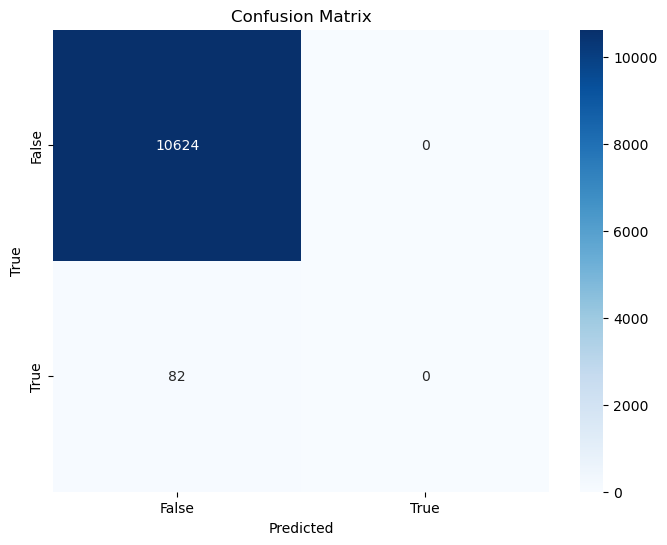

In [417]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()